## Step 1. Load file

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

datapath = './Fraud.csv'
df = pd.read_csv(datapath)
print(df.shape)

(6362620, 11)


## Step 2. Data analysis

Head para demonstrar colunas e as primeiras linhas como exemplo dos dados presentes

In [2]:
print(df.shape[0], 'lines')
df.head()

6362620 lines


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### Colunas


**step** - Mapa para a unidade de tempo no mundo real com uma relação 1x1. Ou seja, cada 1 step representa 1 hora do tempo. Este data set possui 744 steps/horas (30 dias de transações).

**type** - Tipo de transação: CASH-IN (depósito), CASH-OUT (saque), DEBIT (débito), PAYMENT (pagamento) and TRANSFER (transferência)

**amount** - Valor da transação em dólar (USD)

**nameOrig** - Cliente que iniciou a transação

**oldbalanceOrg** - Valor em posse antes da transação

**newbalanceOrig** - Novo valor em posse após transação

**nameDest** - Cliente de origem da transação

**oldbalanceDest** - Valor em posse do cliente destino antes da transação. 
*Não existe informação para clientes que comecem com 'M' (merchants/vendedores)

**newbalanceDest** - Novo valor em posse do cliente destino após transação. *Não existe informação para clientes que comecem com 'M' (merchants/vendedores)

**isFraud** - Representa a classe objetivo. Se aquela transação é fraudulenta ou não.

**isFlaggedFraud** - Coluna provida pela origem do CSV com resposta de um modelo treinado.

In [3]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

### Análise dos atributos

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### Atributo classe objetivo

In [5]:
fraudResume = df.isFraud.value_counts()
fraudResume

0    6354407
1       8213
Name: isFraud, dtype: int64

Podemos observar facilmente que a base é desbalanceada devido uma de suas duas classes representar menos de 0.5% de toda a base.

In [6]:
total = df.isFraud.count()
notFraud = fraudResume[0]
isFraud = fraudResume[1]
notFraudPercent = round((notFraud/total)*100, 3)
isFraudPercent = round((isFraud/total)*100,3)
print('Não é fraude: {}%'.format(notFraudPercent))
print('É fraude: {}%'.format(isFraudPercent))

Não é fraude: 99.871%
É fraude: 0.129%


#### Atributos de treino

###### **step**
devido a natureza deste atributo, analisamos seu histograma, média, mediana e desvio padrão para analisar se as transações aconteceram de forma distribuidas durante o período de 30 dias ou se estas transações estão focadas em algum período determinado.

In [7]:
attStep = df['step']

C:\Users\romulo\AppData\Roaming\Python\Python310\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='step'>

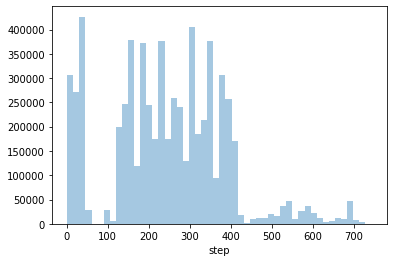

In [8]:
sns.distplot(attStep, kde=False)

In [9]:
step = attStep.describe()
step.apply(lambda s: round(s, 2))

count    6362620.00
mean         243.40
std          142.33
min            1.00
25%          156.00
50%          239.00
75%          335.00
max          743.00
Name: step, dtype: float64

A partir dos dados acima, podemos analisar que a maior parte dos dados ocorre nas primeiras 335 horas (75% das transações).
Isso significa que as transações estão concetradas em um determinado período.

###### **type**
este atributo possui uma boa distribuição entre os tipos PAYMENT, CASH_OUT e CASH_IN. Porém existem pouquíssimos registros do tipo TRANSFER e DEBIT (principalmente)

In [10]:
attType = df['type']
attType.value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

C:\Users\romulo\AppData\Roaming\Python\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='type', ylabel='count'>

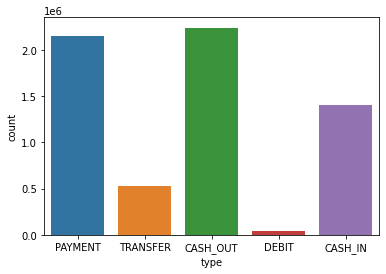

In [11]:
sns.countplot(attType)

###### **atributos financeiros**
Os outros atributos representam informações financeiras. Ou seja, são variáveis contínuas e com valores extremamente específicos. 

In [12]:
amount = df.drop(['step', 'isFraud'], axis=1, inplace=False).describe()
amount.apply(lambda s: round(s, 2))

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud
count,6362620.00,6362620.00,6362620.00,6.362620e+06,6.362620e+06,6362620.0
mean,179861.90,833883.10,855113.67,1.100702e+06,1.224996e+06,0.0
std,603858.23,2888242.67,2924048.50,3.399180e+06,3.674129e+06,0.0
min,0.00,0.00,0.00,0.000000e+00,0.000000e+00,0.0
25%,13389.57,0.00,0.00,0.000000e+00,0.000000e+00,0.0
50%,74871.94,14208.00,0.00,1.327057e+05,2.146614e+05,0.0
75%,208721.48,107315.18,144258.41,9.430367e+05,1.111909e+06,0.0
max,92445516.64,59585040.37,49585040.37,3.560159e+08,3.561793e+08,1.0


Podemos notar que suas médias e desvios padrões são bem distantes, assim como seus mínimos e máximos.

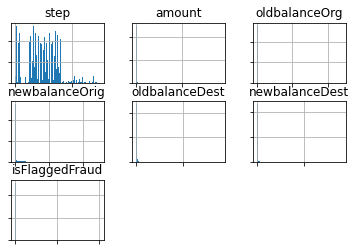

In [13]:
hists = df.drop('isFraud', axis=1, inplace=False).hist(bins=100)
for hist in hists.flatten():
  hist.set_xticklabels([])
  hist.set_yticklabels([])
plt.show()

## Step 3. Data processing

Como podemos notar da análise na etapa anterior, temos dois problemas claros:

1. problema com os dados financeiros que representam valores muito diferentes e únicos, que podem prejudicar os algoritmos.
2. problema com o desbalanceamento da base de dados, onde mais de 99% das transações está representada em apenas 1 classe (não fraude). 

### Removendo linhas e colunas não significativas

Porém, antes de atacar os dois problemas citados, precisamos separar os dados de modo a filtrar apenas linhas com valores válidos e significativos. Ou seja, precisamos remover todos os dados com linha que possuam valores NaN. 

Além disso, pare este caso também removemos as linhas relacionadas a transações de vendedores (clientes começam com M), visto que, de acordo com a descrição da base, estas linhas não possuem valores para análise.

In [14]:
print('Have any null: ', df.isnull().values.any())

Have any null:  False


In [15]:
DFparsed = df.copy(deep=True)
DFparsed.drop(DFparsed[DFparsed['nameOrig'].str.startswith('M')].index, inplace=True)
DFparsed.drop(DFparsed[DFparsed['nameDest'].str.startswith('M')].index, inplace=True)
DFparsed.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.00,1,0
9,1,DEBIT,5337.77,C712410124,41720.0,36382.23,C195600860,41898.0,40348.79,0,0
10,1,DEBIT,9644.94,C1900366749,4465.0,0.00,C997608398,10845.0,157982.12,0,0
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.00,C476402209,5083.0,51513.44,0,0


In [16]:
originalLines = df.shape[0]
newLines = DFparsed.shape[0]
print('Original lines: ', originalLines)
print('Without M on nameOrig: ', newLines)
print('Lines {} removed'.format(originalLines - newLines))

Original lines:  6362620
Without M on nameOrig:  4211125
Lines 2151495 removed


Com isso, removemos mais de 2 milhões de linhas. Entretanto, nenhuma delas está relacionada a nossa classe de menor quantidade (isFraud = 1).

In [17]:
DFparsed['isFraud'].value_counts()

0    4202912
1       8213
Name: isFraud, dtype: int64

### Discretização dos atributos

Precisamos aplicar uma discretização nos atributos financeiros visto sua natureza contínue e variedades de valores únicos.

In [18]:
print('Unique transaction values: ', DFparsed['amount'].nunique())
print('Lines in dataset: ', DFparsed.shape[0])

financialValues = DFparsed.drop(['step', 'isFraud'], axis=1, inplace=False).describe()
financialValues.apply(lambda s: round(s, 2))

Unique transaction values:  4008584
Lines in dataset:  4211125


,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud
count,4211125.00,4211125.00,4211125.00,4.211125e+06,4.211125e+06,4211125.0
mean,265083.46,1225067.68,1260404.15,1.663058e+06,1.850856e+06,0.0
std,727589.12,3482978.00,3523174.12,4.064780e+06,4.386080e+06,0.0
min,0.00,0.00,0.00,0.000000e+00,0.000000e+00,0.0
25%,76085.56,0.00,0.00,1.396590e+05,2.217176e+05,0.0
50%,158943.21,18155.00,0.00,5.512472e+05,6.837248e+05,0.0
75%,278485.01,191127.82,284954.41,1.692951e+06,1.910979e+06,0.0
max,92445516.64,59585040.37,49585040.37,3.560159e+08,3.561793e+08,1.0


In [19]:
balance = DFparsed['amount']
p25 = financialValues['amount']['25%']
p50 = financialValues['amount']['50%']
p75 = financialValues['amount']['75%']
conditions = [
  (balance <= p25),
  (balance > p25) & (balance <= p50),
  (balance > p50) & (balance <= p75),
  (balance > p75)
]
conditions_response = [0, 1, 2, 3]
DFparsed['amount'] = np.select(conditions, conditions_response)

balance = DFparsed['oldbalanceOrg']
p25 = financialValues['oldbalanceOrg']['25%']
p50 = financialValues['oldbalanceOrg']['50%']
p75 = financialValues['oldbalanceOrg']['75%']
conditions = [
  (balance <= p25),
  (balance > p25) & (balance <= p50),
  (balance > p50) & (balance <= p75),
  (balance > p75)
]
conditions_response = [0, 1, 2, 3]
DFparsed['oldbalanceOrg'] = np.select(conditions, conditions_response)

balance = DFparsed['newbalanceOrig']
p25 = financialValues['newbalanceOrig']['25%']
p50 = financialValues['newbalanceOrig']['50%']
p75 = financialValues['newbalanceOrig']['75%']
conditions = [
  (balance <= p25),
  (balance > p25) & (balance <= p50),
  (balance > p50) & (balance <= p75),
  (balance > p75)
]
conditions_response = [0, 1, 2, 3]
DFparsed['newbalanceOrig'] = np.select(conditions, conditions_response)

balance = DFparsed['oldbalanceDest']
p25 = financialValues['oldbalanceDest']['25%']
p50 = financialValues['oldbalanceDest']['50%']
p75 = financialValues['oldbalanceDest']['75%']
conditions = [
  (balance <= p25),
  (balance > p25) & (balance <= p50),
  (balance > p50) & (balance <= p75),
  (balance > p75)
]
conditions_response = [0, 1, 2, 3]
DFparsed['oldbalanceDest'] = np.select(conditions, conditions_response)

balance = DFparsed['newbalanceDest']
p25 = financialValues['newbalanceDest']['25%']
p50 = financialValues['newbalanceDest']['50%']
p75 = financialValues['newbalanceDest']['75%']
conditions = [
  (balance <= p25),
  (balance > p25) & (balance <= p50),
  (balance > p50) & (balance <= p75),
  (balance > p75)
]
conditions_response = [0, 1, 2, 3]
DFparsed['newbalanceDest'] = np.select(conditions, conditions_response)

DFparsed.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,0,C1305486145,1,0,C553264065,0,0,1,0
3,1,CASH_OUT,0,C840083671,1,0,C38997010,0,0,1,0
9,1,DEBIT,0,C712410124,2,2,C195600860,0,0,0,0
10,1,DEBIT,0,C1900366749,1,0,C997608398,0,0,0,0
15,1,CASH_OUT,2,C905080434,1,0,C476402209,0,0,0,0


O próximo passo é transformar os atributos de categoria de palavras em números para que todos os dados possam realmente ser normalizados e utilizados no treinamento deste algoritmo.

In [20]:
DFparsed['type'] = pd.Categorical(DFparsed['type'], ordered=True).codes
DFparsed['nameOrig'] = pd.Categorical(DFparsed.nameOrig, ordered=True).codes
DFparsed['nameDest'] = pd.Categorical(DFparsed.nameDest, ordered=True).codes
DFparsed.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,3,0,663412,1,0,439685,0,0,1,0
3,1,1,0,3859208,1,0,391696,0,0,1,0
9,1,2,0,3580202,2,2,282960,0,0,0,0
10,1,2,0,1958055,1,0,571261,0,0,0,0
15,1,1,2,4000507,1,0,417183,0,0,0,0


Vale lembrar que ao categorizar as colunas de tipo e clientes, estamos inserindo um outro problema no algoritmo. Como as variáveis de categoria se tornaram número, algoritmos que utilizem cálculo de distância entre os valores vão considerar o tipo de transação 2 mais próximo do tipo 1 e, consequentemente, mais longe do tipo 4.

### Correlação dos atributos

In [21]:
DFparsed.corr(method = 'pearson')[['isFraud']]

,isFraud
step,0.039035
type,0.051358
amount,0.025079
nameOrig,-0.000582
oldbalanceOrg,0.044305
newbalanceOrig,-0.033464
nameDest,0.000495
oldbalanceDest,-0.040321
newbalanceDest,-0.023558
isFraud,1.000000


Como podemos ver claramente não existe um único ou até dois atributos que consigam identificar um caso de fraude. Outro fator importante são as colunas *nameOrig* e *nameDest* que demonstram uma correlação aproxima de 0. Ou seja, estes dois atributos não ajudam na identificação da classificação e, por isso, devem ser removidos do conjunto de dados. 

In [22]:
DFparsed.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)
DFparsed.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,3,0,1,0,0,0,1,0
3,1,1,0,1,0,0,0,1,0
9,1,2,0,2,2,0,0,0,0
10,1,2,0,1,0,0,0,0,0
15,1,1,2,1,0,0,0,0,0


### Normalização dos atributos

In [23]:
# normalização min-max
def normalize(dataframe):
    for feature_name in dataframe.columns:
        max_value = dataframe[feature_name].max()
        min_value = dataframe[feature_name].min()
        dataframe[feature_name] = (dataframe[feature_name] - min_value) / (max_value - min_value)

In [24]:
normalize(DFparsed)
DFparsed.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,0.0,1.000000,0.000000,0.333333,0.000000,0.0,0.0,1.0,0.0
3,0.0,0.333333,0.000000,0.333333,0.000000,0.0,0.0,1.0,0.0
9,0.0,0.666667,0.000000,0.666667,0.666667,0.0,0.0,0.0,0.0
10,0.0,0.666667,0.000000,0.333333,0.000000,0.0,0.0,0.0,0.0
15,0.0,0.333333,0.666667,0.333333,0.000000,0.0,0.0,0.0,0.0


### Balançeamento da classe alvo

Existem 2 tipos básicos de balanceamento de base para classes desbalanceadas: simular e inserir registros semelhantes a classe base **ou** remover registros relacionados a classe com maior número.

Para a realidade desta base e deste conceito, não podemos desconsiderar *outliers* pois estes podem justamente ser os casos de fraude. Além disso, simular mais casos randômicos pode criar registros de fraude associando comportamentos que não refletem uma possibilidade real e, assim, prejudicar o aprendizado em qualquer algoritmo.

Por esses motivos, optamos por gerar testes com a base completa e testes com uma base reduzida em que equilibre melhor a classe desbalanceada para uma razão menor.

In [25]:
def print_class_distribution(dataframe):
    fraudResume = dataframe['isFraud'].value_counts()
    total = dataframe['isFraud'].count()
    notFraud = fraudResume[0]
    isFraud = fraudResume[1]
    notFraudPercent = round((notFraud/total)*100, 3)
    isFraudPercent = round((isFraud/total)*100,3)
    print('notFraud: {count} ({percent}%)'.format(count = notFraud, percent = notFraudPercent))
    print('isFraud: {count} ({percent}%)'.format(count = isFraud, percent = isFraudPercent))

DFreduced = DFparsed.drop(
    DFparsed[DFparsed['isFraud'] == 0]
    .sample(frac=.99)
    .index,
    inplace=False
).copy(deep=True)

print('Base Original')
print_class_distribution(DFparsed)

print('\nBase Reduzida')
print_class_distribution(DFreduced)

Base Original
notFraud: 4202912 (99.805%)
isFraud: 8213 (0.195%)

Base Reduzida
notFraud: 42029 (83.653%)
isFraud: 8213 (16.347%)


## Step 4. Training experiments

In [26]:
def split_data(dataframe):
    y = dataframe['isFraud']
    X = dataframe.drop('isFraud', axis=1, inplace=False)
    return train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

def print_splitted_target(train, test):
    trainCount = train.value_counts()
    trainString = '(0={notFraud}; 1={isFraud})'.format(notFraud=trainCount[0], isFraud=trainCount[1])
    testCount = test.value_counts()
    testString = '(0={notFraud}; 1={isFraud})'.format(notFraud=testCount[0], isFraud=testCount[1])
    print('Train: {train} | Test: {test}'.format(train=trainString, test=testString))
    
def avaliate_model(result):
    print('Accuracy: ', metrics.accuracy_score(y_test, result))

    print('\nConfusion Matrix')
    print(confusion_matrix(y_test, result))

    print('\nClassification report')
    print(classification_report(y_test, result, digits=6))
    
import joblib
def save_model(model, filename):
    filename = './{}.sav'.format(filename)
    joblib.dump(model, filename)
    print(filename, ' saved')

### Vale a pena reduzir a dimensionalidade?

In [29]:
from sklearn.manifold import TSNE

X = DFreduced.drop('isFraud', axis=1, inplace=False)
y = DFreduced['isFraud']

X_reduced_tsne = TSNE(n_components=2, random_state=42, n_jobs=3).fit_transform(X.values)

C:\Users\romulo\AppData\Roaming\Python\Python310\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\romulo\AppData\Roaming\Python\Python310\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


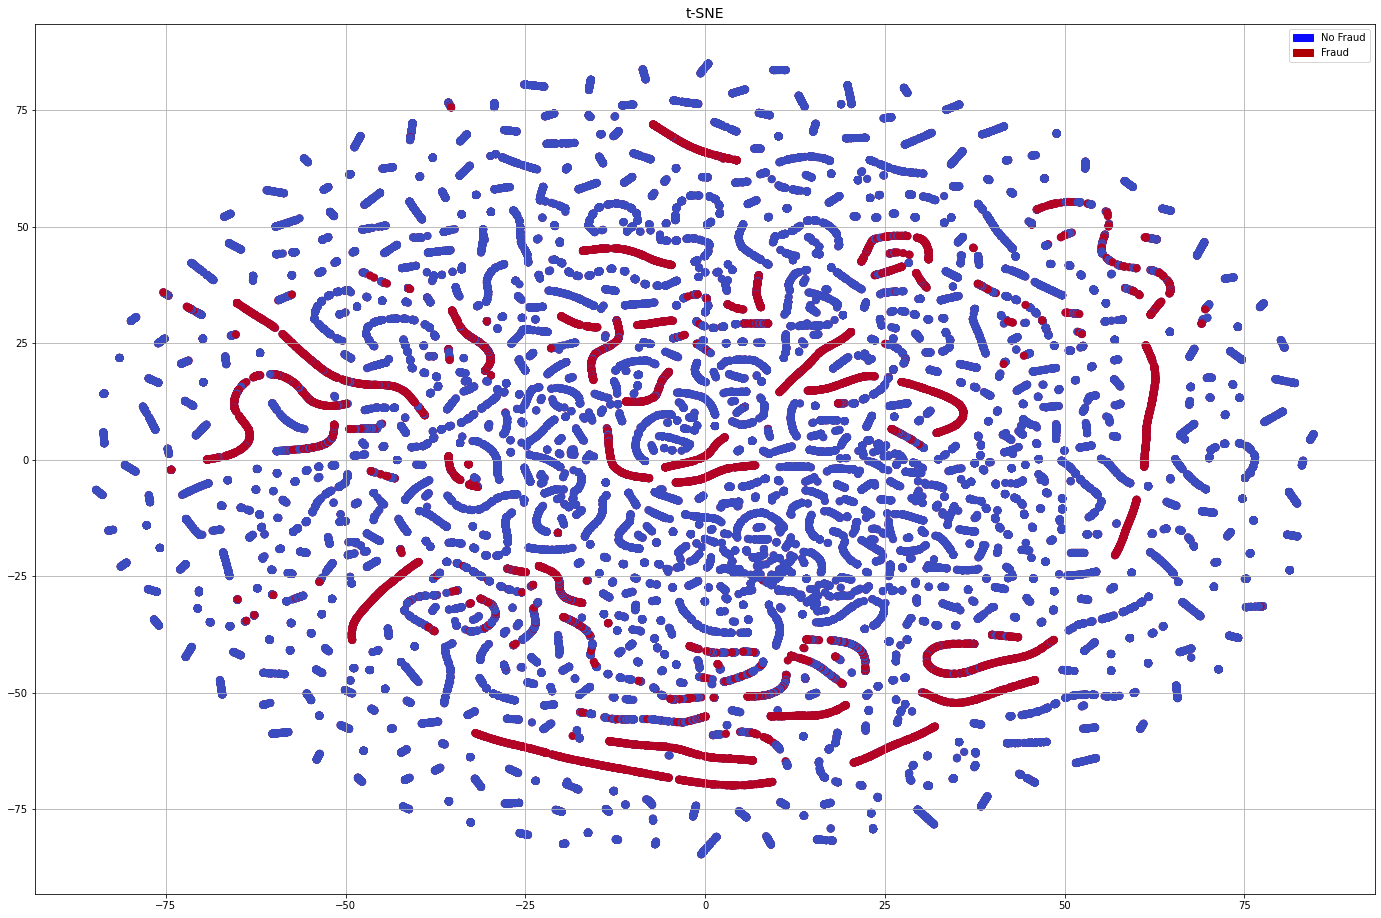

In [31]:
import matplotlib.patches as mpatches

f, ax = plt.subplots(figsize=(24,16))

blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

ax.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax.set_title('t-SNE', fontsize=14)
ax.grid(True)
ax.legend(handles=[blue_patch, red_patch])

Podemos observar que o comportamento das classes não cria um padrão claro e de fácil associação. Por isso optei por não utilizar dados com dimensão reduzida durante os testes de treinamento.

### Decision Tree

In [44]:
from sklearn import tree
from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus

# gerar árvore de decisão completa
def generate_tree(base, model, filename):
    feature_cols = base.columns
    dot_data = StringIO()
    export_graphviz(model, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True,feature_names = feature_cols,class_names=['0','1'])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    graph.write_png('{}.png'.format(filename))
    Image(graph.create_png())

#### com base reduzida

In [45]:
# separar dados de teste e treino
X_train, X_test, y_train, y_test = split_data(DFreduced)
print_splitted_target(y_train, y_test)

Train: (0=33623; 1=6570) | Test: (0=8406; 1=1643)


In [46]:
# treinar e salvar modelo
tree_model = tree.DecisionTreeClassifier()
tree_model = tree_model.fit(X_train, y_train)
save_model(tree_model, 'reduced_decision-tree')

./reduced_decision-tree.sav  saved


In [47]:
# avaliar modelo
y_pred = tree_model.predict(X_test)
avaliate_model(y_pred)

Accuracy:  0.9702457956015524

Confusion Matrix
[[8289  117]
 [ 182 1461]]

Classification report
              precision    recall  f1-score   support

         0.0   0.978515  0.986081  0.982284      8406
         1.0   0.925856  0.889227  0.907172      1643

    accuracy                       0.970246     10049
   macro avg   0.952185  0.937654  0.944728     10049
weighted avg   0.969905  0.970246  0.970003     10049



In [33]:
generate_tree(X_test, tree_model, 'reduced_tree')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.657853 to fit

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.657853 to fit



#### com base original

In [48]:
# separar dados de teste e treino
X_train, X_test, y_train, y_test = split_data(DFparsed)
print_splitted_target(y_train, y_test)

Train: (0=3362330; 1=6570) | Test: (0=840582; 1=1643)


In [49]:
# treinar e salvar modelo
tree_model = tree.DecisionTreeClassifier()
tree_model = tree_model.fit(X_train, y_train)
save_model(tree_model, 'full_decision-tree')

./full_decision-tree.sav  saved


In [50]:
# avaliar modelo
y_pred = tree_model.predict(X_test)
avaliate_model(y_pred)

Accuracy:  0.999205675443023

Confusion Matrix
[[840463    119]
 [   550   1093]]

Classification report
              precision    recall  f1-score   support

         0.0   0.999346  0.999858  0.999602    840582
         1.0   0.901815  0.665247  0.765674      1643

    accuracy                       0.999206    842225
   macro avg   0.950581  0.832552  0.882638    842225
weighted avg   0.999156  0.999206  0.999146    842225



In [37]:
generate_tree(X_test, tree_model, 'full_tree')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.199745 to fit

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.199745 to fit



### k-Nearest Neighbors

In [35]:
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt

#### com base reduzida

In [36]:
# separar dados de teste e treino
X_train, X_test, y_train, y_test = split_data(DFreduced)
print_splitted_target(y_train, y_test)

Train: (0=33623; 1=6570) | Test: (0=8406; 1=1643)


In [37]:
# encontrar melhor K
Ks = 26
mean_acc = np.zeros((Ks-1))
for n in range(1,Ks):
    neigh = KNeighborsClassifier(n_neighbors=n, n_jobs=3).fit(X_train,y_train)
    y_pred = neigh.predict(X_test)
    mean_acc[n-1] = confusion_matrix(y_test, y_pred)[1][1]

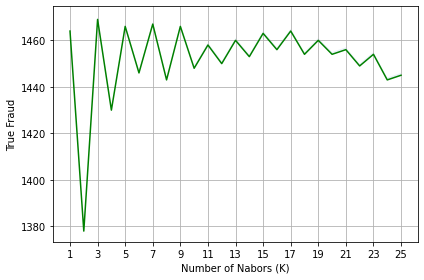

In [38]:
plt.plot(range(1,Ks), mean_acc, 'g')
plt.fill_between(range(1,Ks),mean_acc,mean_acc + 1, alpha=0.10)
plt.ylabel('True Fraud')
plt.xlabel('Number of Nabors (K)')
plt.xticks(range(1,Ks,2))
plt.grid(visible=True, axis='both')
plt.tight_layout()
plt.show()

In [39]:
# treinar e salvar modelo usando melhor K
k = 5
knn_model = KNeighborsClassifier(n_neighbors=k, n_jobs=3)
knn = knn_model.fit(X_train, y_train)
save_model(knn, 'reduced_knn_1')

./reduced_knn_1.sav  saved


In [40]:
# avaliando modelo
y_pred = knn.predict(X_test)
avaliate_model( y_pred)

Accuracy:  0.9711414071051846

Confusion Matrix
[[8293  113]
 [ 177 1466]]

Classification report
              precision    recall  f1-score   support

         0.0   0.979103  0.986557  0.982816      8406
         1.0   0.928436  0.892270  0.909994      1643

    accuracy                       0.971141     10049
   macro avg   0.953769  0.939414  0.946405     10049
weighted avg   0.970819  0.971141  0.970910     10049



#### com base completa

In [41]:
# separar dados de teste e treino
X_train, X_test, y_train, y_test = split_data(DFparsed)
print_splitted_target(y_train, y_test)

Train: (0=3362330; 1=6570) | Test: (0=840582; 1=1643)


In [42]:
# treinar modelo usando melhor K
k = 5
knn_model = KNeighborsClassifier(n_neighbors=k, n_jobs=3)
knn = knn_model.fit(X_train, y_train)
save_model(knn, 'full_knn_1')

./full_knn_1.sav  saved


In [43]:
# avaliando modelo
y_pred = knn.predict(X_test)
avaliate_model( y_pred)

Accuracy:  0.9991142509424441

Confusion Matrix
[[840487     95]
 [   651    992]]

Classification report
              precision    recall  f1-score   support

         0.0   0.999226  0.999887  0.999556    840582
         1.0   0.912603  0.603774  0.726740      1643

    accuracy                       0.999114    842225
   macro avg   0.955915  0.801830  0.863148    842225
weighted avg   0.999057  0.999114  0.999024    842225



### Multi Layer Perceptron

In [27]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

#### com base reduzida

In [32]:
# separar dados de teste e treino
X_train, X_test, y_train, y_test = split_data(DFreduced)
print_splitted_target(y_train, y_test)

Train: (0=33623; 1=6570) | Test: (0=8406; 1=1643)


In [61]:
parameters = {
  'activation': ('identity', 'logistic', 'tanh', 'relu'), 
  'solver': ('lbfgs', 'sgd', 'adam'),
  'hidden_layer_sizes': ([(1,1), (8,1), (8,8), (100,)]),
  'alpha': ([0.0005]),
  'max_iter': ([5000])
}
mlp = MLPClassifier()
clf = GridSearchCV(mlp, parameters, scoring='recall', n_jobs=3)
clf.fit(X_train, y_train)
clf.best_params_

KeyboardInterrupt: 

In [33]:
# treinar e salvar modelo
mlp_model = MLPClassifier(
    hidden_layer_sizes=(3,1000),
    activation='logistic',
    solver='adam', 
    alpha=0.0005, 
    random_state=42, 
    max_iter=1000
)
mlp = mlp_model.fit(X_train, y_train)
save_model(mlp, 'reduced_mlp-adam-log-3x1000')

./reduced_mlp-adam-log-3x1000.sav  saved


In [34]:
# avaliando modelo
y_pred = mlp.predict(X_test)
avaliate_model(y_pred)

Accuracy:  0.9644740770225894

Confusion Matrix
[[8250  156]
 [ 201 1442]]

Classification report
              precision    recall  f1-score   support

         0.0   0.976216  0.981442  0.978822      8406
         1.0   0.902378  0.877663  0.889849      1643

    accuracy                       0.964474     10049
   macro avg   0.939297  0.929552  0.934335     10049
weighted avg   0.964143  0.964474  0.964275     10049



#### com base original

In [29]:
# separar dados de teste e treino
X_train, X_test, y_train, y_test = split_data(DFparsed)
print_splitted_target(y_train, y_test)

Train: (0=3362330; 1=6570) | Test: (0=840582; 1=1643)


In [30]:
# treinar e salvar modelo
mlp_model = MLPClassifier(
    hidden_layer_sizes=(3,1000),
    activation='logistic',
    solver='adam', 
    alpha=0.0005, 
    random_state=42, 
    max_iter=1000
)
mlp = mlp_model.fit(X_train, y_train)
save_model(mlp, 'full_mlp-adam-log-3x1000')

./full_mlp-adam-log-3x1000.sav  saved


In [31]:
# avaliando modelo
y_pred = mlp.predict(X_test)
avaliate_model(y_pred)

Accuracy:  0.9988577874083528

Confusion Matrix
[[840552     30]
 [   932    711]]

Classification report
              precision    recall  f1-score   support

         0.0   0.998892  0.999964  0.999428    840582
         1.0   0.959514  0.432745  0.596477      1643

    accuracy                       0.998858    842225
   macro avg   0.979203  0.716355  0.797952    842225
weighted avg   0.998816  0.998858  0.998642    842225



### C-Support Vector Classification

In [55]:
from sklearn import svm

#### com base reduzida

In [56]:
# separar dados de teste e treino
X_train, X_test, y_train, y_test = split_data(DFreduced)
print_splitted_target(y_train, y_test)

Train: (0=29420; 1=5749) | Test: (0=12609; 1=2464)


In [ ]:
parameters = {
  'kernel': ('linear', 'poly', 'rbf', 'sigmoid', 'precomputed'), 
  'class_weight': (['balanced', {0: 0.2, 1: 0.8}])
}
svc = svm.SVC()
#clf = GridSearchCV(svc, parameters, scoring='recall', n_jobs=3)
#clf.fit(X_train, y_train)
#clf.best_params_

In [57]:
# treinar e salvar modelo
svc_model = svm.SVC(kernel='rbf')
#svc = svm_model.fit(X_train, y_train)
#save_model(svc, 'reduced_svc')

./reduced_svm_rbf.sav  saved


In [58]:
# avaliando modelo
#y_pred = svc.predict(X_test)
#avaliate_model(y_pred)

Accuracy:  0.8535792476613813

Confusion Matrix
[[12117   492]
 [ 1715   749]]

Classification report
              precision    recall  f1-score   support

           0   0.876012  0.960980  0.916531     12609
           1   0.603546  0.303977  0.404318      2464

    accuracy                       0.853579     15073
   macro avg   0.739779  0.632479  0.660425     15073
weighted avg   0.831472  0.853579  0.832799     15073



#### com base original

In [56]:
# separar dados de teste e treino
X_train, X_test, y_train, y_test = split_data(DFparsed)
print_splitted_target(y_train, y_test)

Train: (0=29420; 1=5749) | Test: (0=12609; 1=2464)


In [57]:
# treinar e salvar modelo
svc_model = svm.SVC(kernel='rbf')
#svc = svc_model.fit(X_train, y_train)
#save_model(svc, 'full_svc')

./reduced_svm_rbf.sav  saved


In [58]:
# avaliando modelo
#y_pred = svc.predict(X_test)
#avaliate_model(y_pred)

Accuracy:  0.8535792476613813

Confusion Matrix
[[12117   492]
 [ 1715   749]]

Classification report
              precision    recall  f1-score   support

           0   0.876012  0.960980  0.916531     12609
           1   0.603546  0.303977  0.404318      2464

    accuracy                       0.853579     15073
   macro avg   0.739779  0.632479  0.660425     15073
weighted avg   0.831472  0.853579  0.832799     15073

